In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load flight delay dataset
flights_df = pd.read_csv('/content/Airline_Delay_Cause.csv')

# Load weather dataset (NOAA data)
weather_df = pd.read_csv('/content/3988168.csv')


In [3]:
# Check first few rows
print(flights_df.head())
print(weather_df.head())

# Check shape and column names
print(flights_df.shape)
print(flights_df.columns)

print(weather_df.shape)
print(weather_df.columns)


   year  month carrier               carrier_name airport  \
0  2024     12      OO      SkyWest Airlines Inc.     JFK   
1  2024     12      9E          Endeavor Air Inc.     JFK   
2  2024     12      AA  American Airlines Network     JFK   
3  2024     12      AS    Alaska Airlines Network     JFK   
4  2024     12      B6            JetBlue Airways     JFK   

                                  airport_name  arr_flights  arr_del15  \
0  New York, NY: John F. Kennedy International        201.0       47.0   
1  New York, NY: John F. Kennedy International       1004.0      232.0   
2  New York, NY: John F. Kennedy International       1155.0      258.0   
3  New York, NY: John F. Kennedy International        356.0      105.0   
4  New York, NY: John F. Kennedy International       3142.0      887.0   

   carrier_ct  weather_ct  ...  security_ct  late_aircraft_ct  arr_cancelled  \
0       28.09        6.83  ...         0.00              0.00            2.0   
1       56.29       10.58  .

In [4]:
# Step 1: Extract year and month from DATE in weather dataset
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])
weather_df['year'] = weather_df['DATE'].dt.year
weather_df['month'] = weather_df['DATE'].dt.month

# Step 2: Group weather data by year and month (mean values)
weather_monthly = weather_df.groupby(['year', 'month']).agg({
    'AWND': 'mean',
    'PRCP': 'mean',
    'TMAX': 'mean',
    'TMIN': 'mean'
}).reset_index()

# Step 3: Merge with flight dataset on year and month
merged_df = pd.merge(flights_df, weather_monthly, on=['year', 'month'], how='inner')

# Step 4: Drop any rows with missing values (optional but clean)
merged_df.dropna(inplace=True)

# Step 5: Check structure
print(merged_df.shape)
print(merged_df.head())

(586, 25)
   year  month carrier               carrier_name airport  \
0  2024     12      OO      SkyWest Airlines Inc.     JFK   
1  2024     12      9E          Endeavor Air Inc.     JFK   
2  2024     12      AA  American Airlines Network     JFK   
3  2024     12      AS    Alaska Airlines Network     JFK   
4  2024     12      B6            JetBlue Airways     JFK   

                                  airport_name  arr_flights  arr_del15  \
0  New York, NY: John F. Kennedy International        201.0       47.0   
1  New York, NY: John F. Kennedy International       1004.0      232.0   
2  New York, NY: John F. Kennedy International       1155.0      258.0   
3  New York, NY: John F. Kennedy International        356.0      105.0   
4  New York, NY: John F. Kennedy International       3142.0      887.0   

   carrier_ct  weather_ct  ...  arr_delay  carrier_delay  weather_delay  \
0       28.09        6.83  ...     5089.0         3307.0          634.0   
1       56.29       10.58  .

<Axes: >

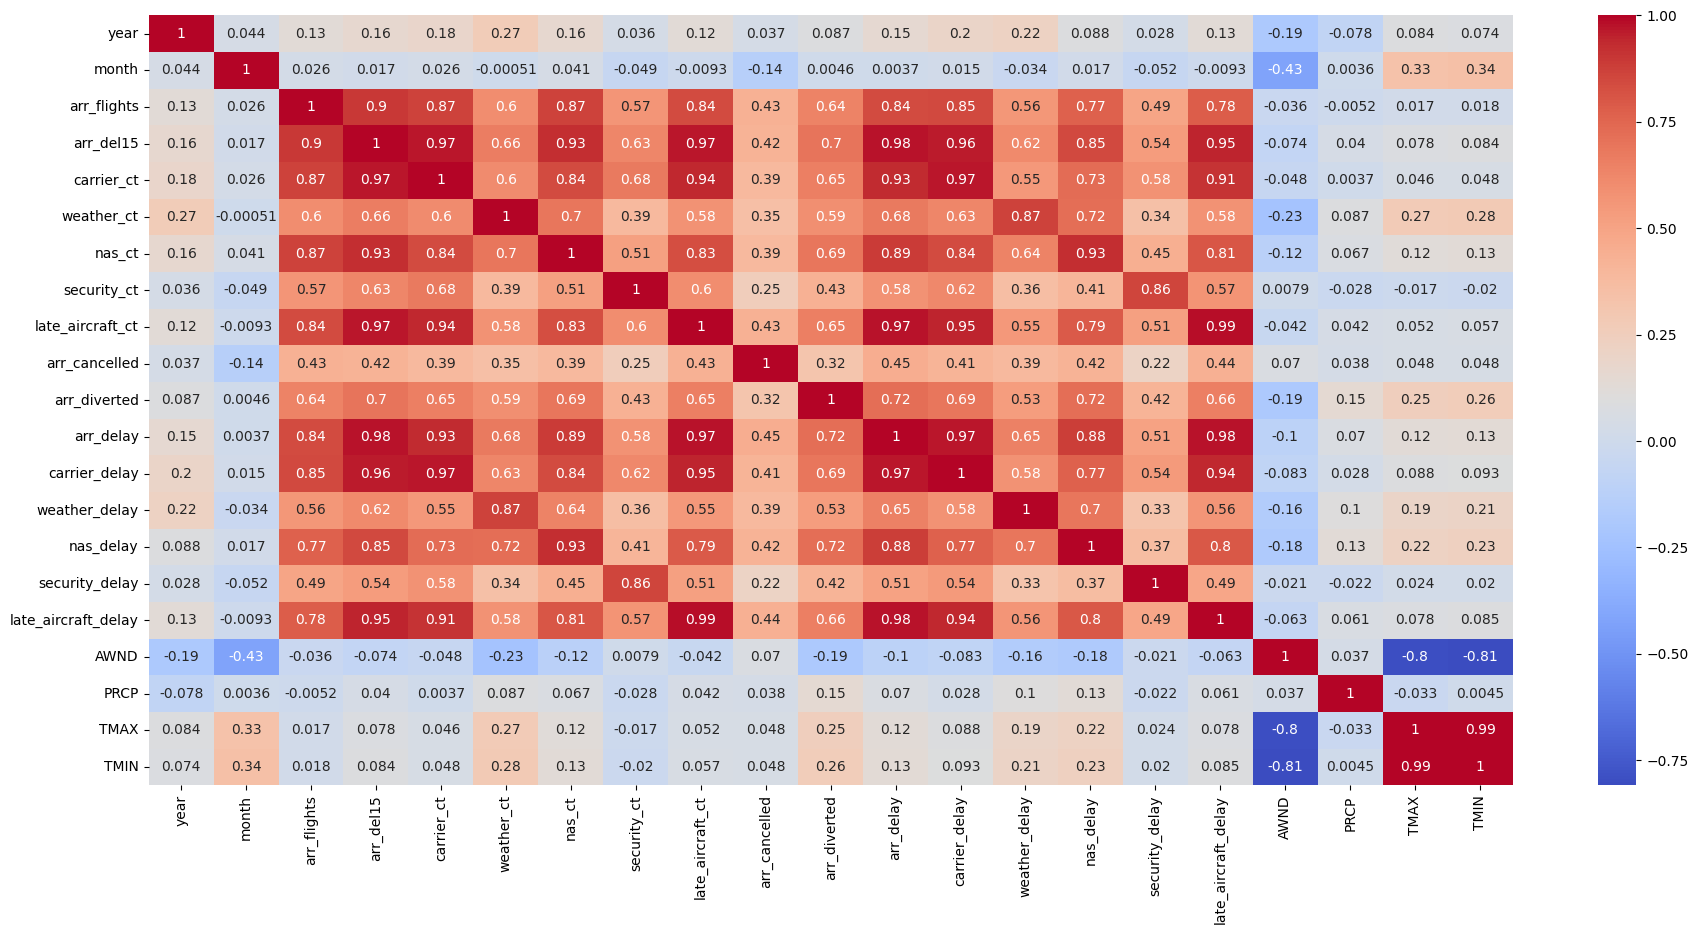

In [5]:
# Only keep numeric columns for correlation analysis (HeatMap)
numeric_cols = merged_df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(22,10))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm")



In [6]:
to_drop = [
    'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
    'security_delay', 'late_aircraft_delay',
    'carrier_ct', 'nas_ct', 'late_aircraft_ct', 'arr_diverted', 'arr_cancelled'
]
merged_df_cleaned = merged_df.drop(columns=to_drop)


In [7]:
merged_df['delay_ratio'] = merged_df['arr_del15'] / merged_df['arr_flights']


In [8]:
merged_df['is_delayed'] = merged_df['delay_ratio'].apply(lambda x: 1 if x > 0.2 else 0)


In [9]:
merged_df['is_delayed'].value_counts()


,count
is_delayed,
0,329
1,257


In [10]:
# Drop irrelevant or target-related columns
features = merged_df.drop(columns=[
    'arr_del15', 'delay_ratio', 'is_delayed', 'carrier', 'carrier_name', 'airport', 'airport_name'
])
target = merged_df['is_delayed']

Confusion Matrix:
[[83 13]
 [23 57]]
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        96
           1       0.81      0.71      0.76        80

    accuracy                           0.80       176
   macro avg       0.80      0.79      0.79       176
weighted avg       0.80      0.80      0.79       176



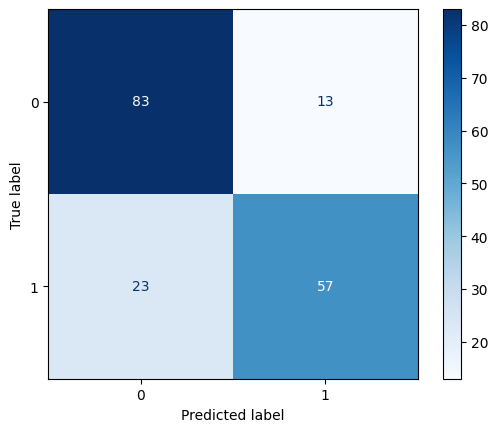

In [11]:
# Split data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

# Make predictions and evaluate
y_pred = clf.predict(X_test_scaled)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))        # Confusion matrix
print(classification_report(y_test, y_pred))   # Precision, recall, f1-score, accuracy

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')

In [12]:
# Add new features
merged_df['temp_diff'] = merged_df['TMAX'] - merged_df['TMIN']
merged_df['wind_flag'] = (merged_df['AWND'] > 10).astype(int)
merged_df['rain_flag'] = (merged_df['PRCP'] > 0).astype(int)

# Encode categorical features
le = LabelEncoder()
merged_df['carrier_encoded'] = le.fit_transform(merged_df['carrier'])

# Optional: ensure month is int (not float)
merged_df['month'] = merged_df['month'].astype(int)


In [13]:
features = ['AWND', 'PRCP', 'TMAX', 'TMIN', 'temp_diff', 'wind_flag', 'rain_flag', 'month', 'arr_flights', 'carrier_encoded']


              precision    recall  f1-score   support

           0       0.83      0.91      0.87        96
           1       0.87      0.78      0.82        80

    accuracy                           0.85       176
   macro avg       0.85      0.84      0.84       176
weighted avg       0.85      0.85      0.85       176

Confusion Matrix:
[[87  9]
 [18 62]]


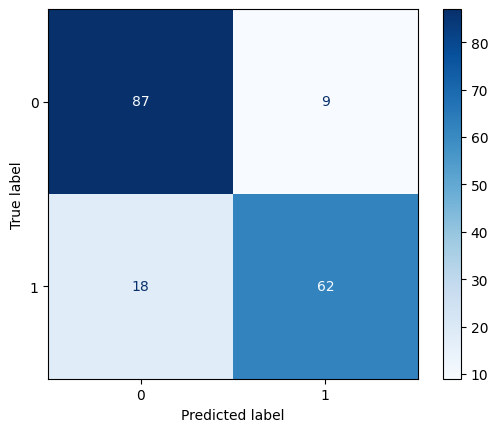

In [14]:
# Train XGBoost classifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Print evaluation metrics
print(classification_report(y_test, y_pred))      # Precision, recall, f1-score, accuracy
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))           # Raw confusion matrix

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')


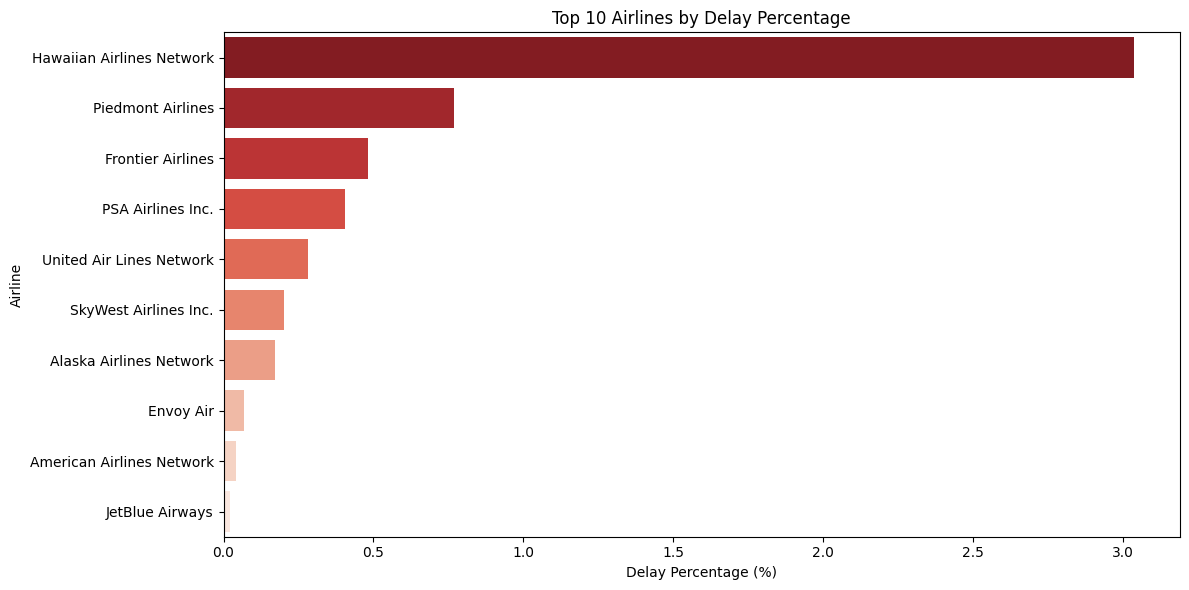

In [15]:
# Q1: Which airlines have the highest delay percentage?

# Group by carrier and calculate total & delayed flights
carrier_delay_stats = merged_df.groupby('carrier_name').agg(
    total_flights=('arr_flights', 'sum'),
    delayed_flights=('is_delayed', 'sum')
).reset_index()

# Calculate delay percentage
carrier_delay_stats['delay_percentage'] = (carrier_delay_stats['delayed_flights'] / carrier_delay_stats['total_flights']) * 100

# Sort top 10
top_carrier_delays = carrier_delay_stats.sort_values('delay_percentage', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_carrier_delays,
    x='delay_percentage',
    y='carrier_name',
    hue='carrier_name',   # Set hue to match y-axis
    dodge=False,          # Prevents grouped bars
    palette='Reds_r',
    legend=False          # We don't need the hue legend since y-axis shows carrier names
)
plt.title("Top 10 Airlines by Delay Percentage")
plt.xlabel("Delay Percentage (%)")
plt.ylabel("Airline")
plt.tight_layout()
plt.show()


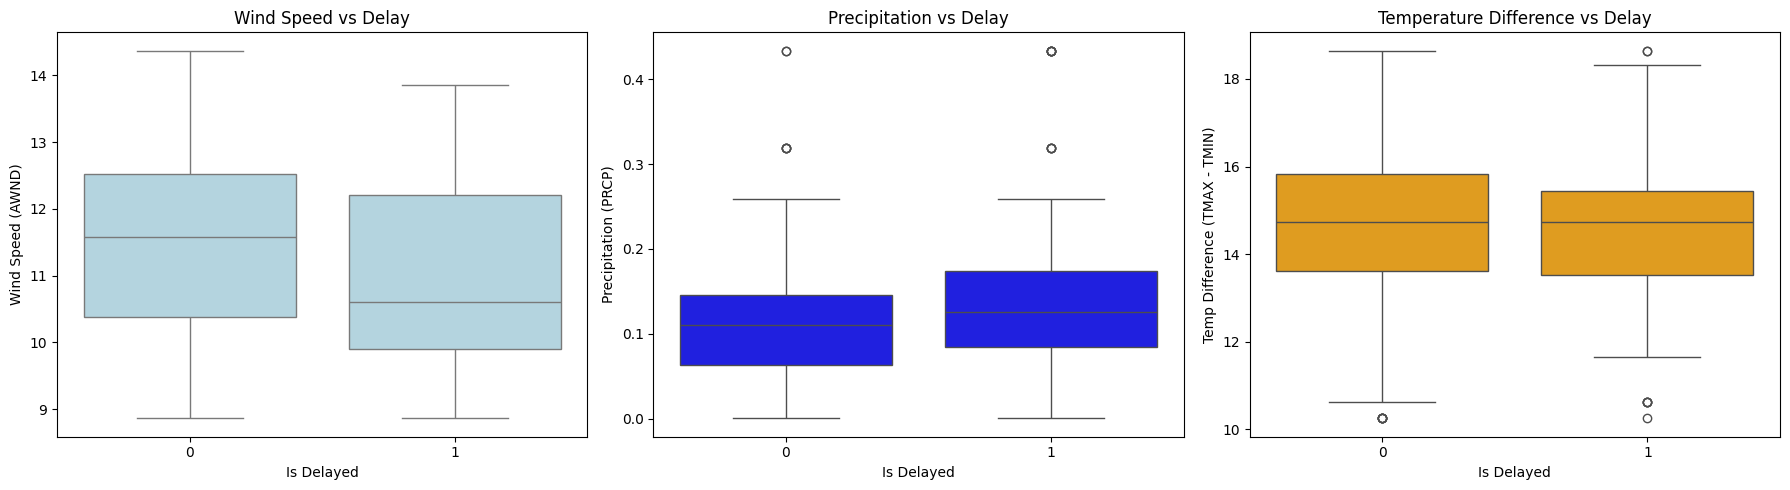

In [16]:
# Q2: Does weather (wind, rain, temp) affect delays?

# Boxplots to compare weather metrics across delay classes
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data=merged_df, x='is_delayed', y='AWND', ax=axs[0], color='lightblue')
axs[0].set_title('Wind Speed vs Delay')
axs[0].set_xlabel('Is Delayed')
axs[0].set_ylabel('Wind Speed (AWND)')

sns.boxplot(data=merged_df, x='is_delayed', y='PRCP', ax=axs[1], color='blue')
axs[1].set_title('Precipitation vs Delay')
axs[1].set_xlabel('Is Delayed')
axs[1].set_ylabel('Precipitation (PRCP)')

sns.boxplot(data=merged_df, x='is_delayed', y='temp_diff', ax=axs[2], color='orange')
axs[2].set_title('Temperature Difference vs Delay')
axs[2].set_xlabel('Is Delayed')
axs[2].set_ylabel('Temp Difference (TMAX - TMIN)')

plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

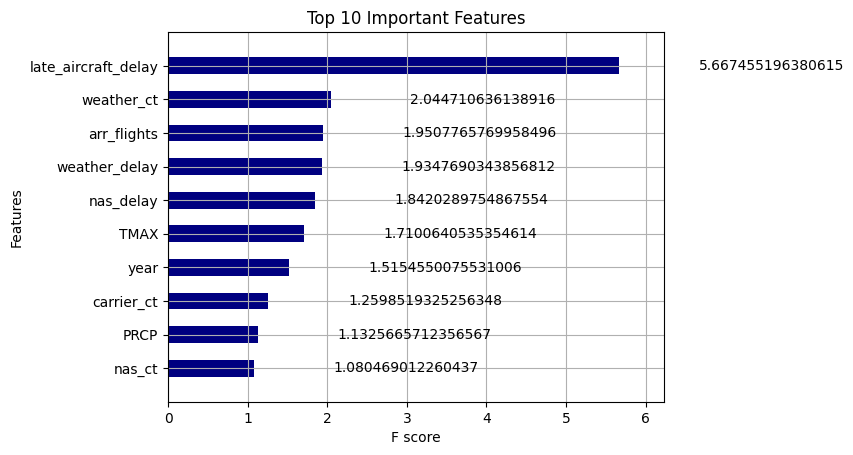

<Figure size 640x480 with 0 Axes>

In [17]:
# Q3: Visualize top features used by the model

# If not already done:
from xgboost import plot_importance

plt.figure(figsize=(12, 6))
plot_importance(xgb_model, max_num_features=10, importance_type='gain', height=0.5, title='Top 10 Important Features', color='navy')
plt.show()
plt.tight_layout()
plt.show()


In [18]:
# Get the columns from the training dataset
X_train_columns = X_train.columns

# Ensure the features used for prediction are aligned with those used in training
X_full = merged_df[X_train_columns]

# Apply the same scaling
X_full_scaled = scaler.transform(X_full)

# Make predictions using the trained model
merged_df['prediction'] = xgb_model.predict(X_full_scaled)

# Export the complete dataset with predictions to CSV
merged_df.to_csv("/content/flight_delay_predictions.csv", index=False)

